In [1]:
import os
import time
import PIL
import glob 
import base64 # Decode Image
import random
import requests
import numpy as np
import pandas as pd
from PIL import Image # Graph Images
from skimage import io # Modify Image
import tensorflow as tf
from pathlib import Path
from splinter import Browser # Automate Webactions
from os.path  import basename
from bs4 import BeautifulSoup as soup # Scrape Webdata
from sklearn.model_selection import train_test_split
from webdriver_manager.chrome import ChromeDriverManager # brew install chromedriver
from sklearn.preprocessing import StandardScaler,OneHotEncoder

## Scrape Produce Data
### Get Produce Names

In [2]:
executable_path = {'executable_path': ChromeDriverManager().install()} # webdriver to automate chrome
browser = Browser('chrome', **executable_path, headless=False)

# visit fruits and vegitables website
browser.visit('https://fruitsandveggies.org/stories/fruit-and-veggie-color-list/')
fruitnveg_soup = soup(browser.html, 'html.parser') # convert to soup object
produce = fruitnveg_soup.table.find_all('a') # find all fruits and vegetables
for item in range(len(produce)): # extract names from soup object
    produce[item] = produce[item].get_text() # add current item to list

print('There are '+str(len(produce))+' Produce items considered')   
print(produce[:5])



====== WebDriver manager ======
Current google-chrome version is 105.0.5195
Get LATEST chromedriver version for 105.0.5195 google-chrome
Driver [/Users/brandon/.wdm/drivers/chromedriver/mac64/105.0.5195.52/chromedriver] found in cache


There are 121 Produce items considered
['Red Apples', 'Blood Oranges', 'Cherries', 'Cranberries', 'Red Grapes']


### Get Produce Pictures

In [3]:
def download_images(links, name, dirname, j): # Google images host through encodedbytes
    png_array=  links
    png_array = png_array.split(",")
    png_array = png_array[1].encode()
    pathImg = dirname+'/'+name+str(j)+'.png'
    fh = open(pathImg, "wb")
    fh.write(base64.decodebytes(png_array))
    fh.close()

produce_table = {'nameId':[],'name':[],'width':[],'height':[],'encodedPic':[]} # Initialize DataFrame
for item in produce:
    if item != '': # If item is not null
        item = item.replace(' ','_') # Clean name
        image_path = 'Pictures/'+item
        try:
            os.mkdir(image_path) # Create directory to hold fruit-pics
        except:
            print('Directory Exists')

        home = 'https://images.google.com/' # Define 'Homepage'
        browser.visit(home) # Go to google
        time.sleep(random.random()*random.randint(1,6)) # Randomization, avoids chromes CAPTCHA
        browser.find_by_xpath( # Fill item
            '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/div/div[2]/input'
        ).fill(item)
        time.sleep(random.random()*random.randint(1,3))
        browser.find_by_xpath( # Click search button
            '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/button'
        ).click()

        Picture_soup = soup(browser.html, 'html.parser') # Convert Item Image Page to Soup
        Produce_Item_Images = Picture_soup.find_all('img') # Get all Images of Item
        j=0 # initailize counter
        for i in range(len(Produce_Item_Images)): # Download top images
            if Produce_Item_Images[i].get('data-deferred') == '1': # If top images
                lnk = Produce_Item_Images[i].get('src') # Get src
                try:
                    download_images(lnk, item, image_path, j) # Download image with unique naming
                    new_image_path = image_path+'/'+item+str(j)+'.png'
                    get_encoding = glob.glob(new_image_path)
                    image = io.imread(get_encoding[0]) # Encode Image in RGB
                    produce_table['nameId'].append(new_image_path) # Add attributes to DataFrame
                    produce_table['name'].append(item) 
                    produce_table['width'].append(len(image[0])) # Double check images were cropped
                    produce_table['height'].append(len(image)) 
                    produce_table['encodedPic'].append(image)            
                        
                except:
                    status = 0
                    
                j += 1

raw_produce = pd.DataFrame(produce_table)
raw_produce.head()

Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exists
Directory Exis

,nameId,name,width,height,encodedPic
0,Pictures/Red_Apples/Red_Apples1.png,Red_Apples,100,100,"[[[110, 109, 123], [109, 108, 122], [107, 106,..."
1,Pictures/Red_Apples/Red_Apples2.png,Red_Apples,100,100,"[[[255, 254, 255], [255, 255, 255], [255, 255,..."
2,Pictures/Red_Apples/Red_Apples3.png,Red_Apples,100,100,"[[[255, 255, 255], [255, 255, 255], [255, 254,..."
3,Pictures/Red_Apples/Red_Apples4.png,Red_Apples,100,100,"[[[209, 209, 209], [209, 209, 209], [209, 209,..."
4,Pictures/Red_Apples/Red_Apples5.png,Red_Apples,100,100,"[[[55, 45, 10], [45, 39, 5], [59, 56, 25], [55..."


## Preprocess Images

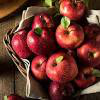

In [25]:
data_dir = Path('Pictures/')


apples = list(data_dir.glob('Red_Apples/*'))
PIL.Image.open(apples[0])


In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory( # Define Directory of Images
    data_dir, validation_split=0.2, subset="training", seed=123, 
    image_size=(100, 100), batch_size=32)

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

Found 3807 files belonging to 116 classes.
Using 3046 files for training.
3807


In [27]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation", seed=123,
    image_size=(100, 100), batch_size=32)

Found 3807 files belonging to 116 classes.
Using 761 files for validation.


In [28]:
class_names = train_ds.class_names
print(class_names)

['Apricots', 'Artichokes', 'Arugula', 'Asparagus', 'Avocados', 'Bananas', 'Beets', 'Black_Currants', 'Black_Olives_', 'Black_Salsify', 'Blackberries', 'Blood_Oranges', 'Blueberries', 'Broccoflower_', 'Broccoli', 'Broccoli_Rabe', 'Brown_Pears', 'Brussels_Sprouts', 'Butternut_Squash', 'Cantaloupe', 'Cape_Gooseberries', 'Carrots', 'Cauliflower', 'Celery', 'Chayote_Squash', 'Cherries', 'Chinese_Cabbage', 'Concord_Grapes', 'Cranberries', 'Cucumbers', 'Dates', 'Dried_Plums', 'Eggplant', 'Elderberries', 'Endive', 'Garlic', 'Ginger', 'Golden_Kiwifruit', 'Grape_Juice_(100%)', 'Grapefruit', 'Green_Apples', 'Green_Beans', 'Green_Cabbage', 'Green_Grapes', 'Green_Onions', 'Green_Peas', 'Green_Peppers', 'Honeydew', 'Jerusalem_Artichokes', 'Jicama', 'Kiwifruit', 'Kohlrabi', 'Leeks', 'Lemons', 'Lettuce', 'Limes', 'Mangoes', 'Mushrooms', 'Nectarines', 'Okra', 'Onions', 'Oranges', 'Papayas', 'Parsnips', 'Peaches', 'Peas', 'Persimmons', 'Pineapples', 'Plums', 'Pomegranates', 'Potatoes_(White_Fleshed)', '

In [8]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

In [29]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 100, 100, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

### Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling

In [30]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- Dataset.prefetch overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.




In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names))
])

In [37]:
model.compile(optimizer='adam', metrics=['accuracy'],
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))


In [38]:
model.fit(train_ds, validation_data=val_ds, epochs=7)

Epoch 1/7
96/96 [==============================] - 19s 193ms/step - loss: 4.7299 - accuracy: 0.0098 - val_loss: 4.5879 - val_accuracy: 0.0276
Epoch 2/7
96/96 [==============================] - 21s 217ms/step - loss: 4.2716 - accuracy: 0.0407 - val_loss: 3.9301 - val_accuracy: 0.0486
Epoch 3/7
96/96 [==============================] - 21s 214ms/step - loss: 3.8234 - accuracy: 0.0854 - val_loss: 3.7500 - val_accuracy: 0.0933
Epoch 4/7
96/96 [==============================] - 21s 216ms/step - loss: 3.5692 - accuracy: 0.1297 - val_loss: 3.6397 - val_accuracy: 0.1301
Epoch 5/7
96/96 [==============================] - 21s 217ms/step - loss: 3.2801 - accuracy: 0.1891 - val_loss: 3.6621 - val_accuracy: 0.1472
Epoch 6/7
96/96 [==============================] - 21s 217ms/step - loss: 2.9878 - accuracy: 0.2587 - val_loss: 3.7583 - val_accuracy: 0.1459
Epoch 7/7
96/96 [==============================] - 21s 217ms/step - loss: 2.7422 - accuracy: 0.3129 - val_loss: 3.8888 - val_accuracy: 0.1367


## Make Predictions

In [40]:
img = Path('Test')
img_generator = tf.keras.preprocessing.image_dataset_from_directory(
    img, batch_size=32, image_size=(100,100)
)
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = img_generator.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

AUTOTUNE = tf.data.AUTOTUNE

img_generator = img_generator.cache().prefetch(buffer_size=AUTOTUNE)

Found 1 files belonging to 1 classes.
0.0 1.0


In [47]:
preds = model.predict(img_generator)
pd.DataFrame(preds, columns = class_names)

1/1 [==============================] - 0s 10ms/step


,Apricots,Artichokes,Arugula,Asparagus,Avocados,Bananas,Beets,Black_Currants,Black_Olives_,Black_Salsify,...,Yellow_Apples,Yellow_Beets,Yellow_Figs,Yellow_Pears,Yellow_Peppers,Yellow_Potatoes,Yellow_Summer_Squash,Yellow_Tomatoes,Yellow_Watermelon,Zucchini
0,-3.709516,-11.84239,-10.394814,-12.435935,-15.505508,-10.20803,0.02225,-4.617765,-6.692712,-9.867864,...,-9.334214,-6.154724,-3.856964,-11.810272,-10.68259,-11.225958,-14.611511,-11.966071,-6.862919,-11.636515
